## Criando um Sistema de Reconhecimento Facial do Zero

Desafio de projeto

Autor: Israel de Castro Evangelista

Objetivo: Criação de um sistema de detecção e reconhecimento de faces, utilizando o framework TensorFlow em conjuntos com as bibliotecas necessárias de forma ilimitada.

In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow

import tensorflow as tf
import cv2
import numpy as np
import PIL
import io
import html
import time

Clonando e Configurando a Darknet para YOLOv4

In [2]:
# clonando repositório darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.16 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (10413/10413), done.


In [3]:
# Alterando o arquivo makefile para ter a GPU, OPENCV e LIBSO habilitados
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |            

In [5]:
# Obtendo o arquivo de pesos escalados do YOLOv4 pré-treinados para detectar 80 classes (objetos) a partir do compartilhamento do Google Drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2023-04-15 21:52:33--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 142.250.99.102, 142.250.99.101, 142.250.99.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p42p7fj2h4ndg87a3q62qv7gmoso4vqu/1681595550000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=28137b74-3764-4127-a556-93f77619d254 [following]
--2023-04-15 21:52:33--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p42p7fj2h4ndg87a3q62qv7gmoso4vqu/1681595550000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=28137b74-3764-4127-a556-93f77619d254
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 74.125.20.132, 2

In [6]:
!ls


3rdparty		darknet_video.py       obj
backup			data		       README.md
build			image_yolov3.sh        results
build.ps1		image_yolov4.sh        scripts
cfg			include		       src
cmake			json_mjpeg_streams.sh  uselib
CMakeLists.txt		libdarknet.so	       vcpkg.json
darknet			LICENSE		       vcpkg.json.opencv23
DarknetConfig.cmake.in	Makefile	       video_yolov3.sh
darknet_images.py	net_cam_v3.sh	       video_yolov4.sh
darknet.py		net_cam_v4.sh	       yolov4-csp.weights


# Darknet para Python
Para utilizar o YOLOv4 com código Python, vamos usar algumas das funções pré-construídas encontradas dentro do arquivo darknet.py, importando essas funções para a nossa estação de trabalho.

In [7]:
# Importando as funções do darknet para realizar detecções de objetos
from darknet import *

# Carreguando em nossa rede a arquitetura YOLOv4
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# Função auxiliar do darknet para executar a detecção em uma imagem
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # Obtendo as proporções da imagem para converter as caixas delimitadoras para o tamanho apropriado
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # Executando o modelo em uma imagem no estilo darknet para obter as detecções
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## Exemplo YOLOv4 em uma imagem de teste
Vamos garantir que nosso modelo tenha sido carregado com sucesso e que possamos fazer detecções corretamente em uma imagem de teste.

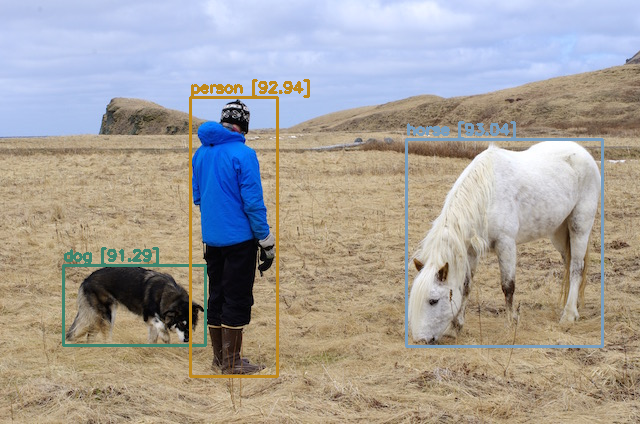

In [8]:
# Executando um teste na imagem person.jpg que vem com o repositório
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Funções de ajuda
<p> 
Abaixo estão algumas funções auxiliares para fazer a conversão entre diferentes tipos e formatos de dados de imagem.
</p>

In [9]:
# Função para converter o objeto JavaScript em uma imagem OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # Decodificando a imagem em base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # Convertendo bytes para um array numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # Decodificando o array numpy em uma imagem OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Função para converter a imagem de caixa delimitadora retangular do OpenCV em uma string de bytes em base64 para ser sobreposta no fluxo de vídeo
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # Convertendo o array em uma imagem PIL (Python Imaging Library)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # Formatando a caixa delimitadora em png para retorno
  bbox_PIL.save(iobuf, format='png')
  # Formatando a string de retorno
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Classificador de Haar Cascade
Para este tutorial, executaremos um algoritmo simples de detecção de objetos chamado Haar Cascade em nossas imagens e vídeo capturado pela webcam. O OpenCV possui um modelo de detecção de rosto pré-treinado Haar Cascade.

In [10]:
# Inicializando o modelo de detecção de rosto Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Imagens da Webcam
A execução de código em imagens capturadas pela webcam é bastante simples. Utilizaremos o trecho de código denominado **Snippets** do Google Colab, que possui uma variedade de funções úteis para realizar várias tarefas.

Usaremos o trecho de código para **Captura de Câmera** para utilizar a webcam do seu computador.

In [11]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Redimensionando a saída para ajustá-la ao elemento de vídeo
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Aguardando a captura ser clicada
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # Obtendo os dados da foto
  data = eval_js('takePhoto({})'.format(quality))
  # Obtendo a imagem no formato OpenCV
  img = js_to_image(data) 
  # Tons de cinza img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # Obtendo as coordenadas da caixa delimitadora do rosto usando o Haar Cascade
  faces = face_cascade.detectMultiScale(gray)

  # Desenhando a caixa delimitadora do rosto na imagem
  for (x,y,w,h) in faces:
      image = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      
      detections, width_ratio, height_ratio = darknet_helper(image, w, h)
      for label, confidence, bbox in detections:
        cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          class_colors[label], 2)


  # savando imagem
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


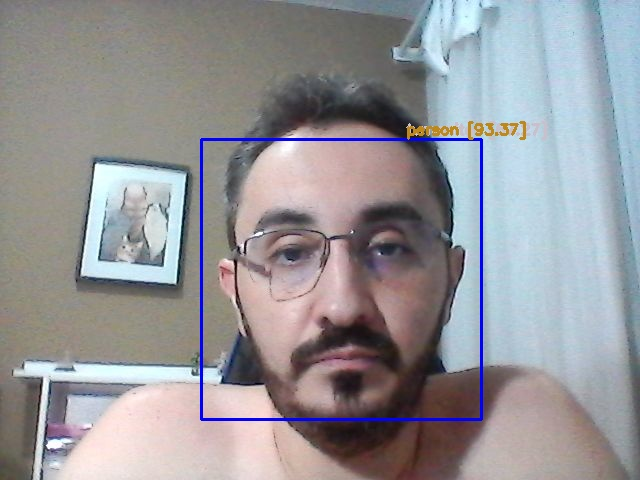

In [12]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Mostrando a imagem que acabou de ser capturada
  display(Image(filename))
except Exception as err:
  # Erros serão apresentados se o usuário não tiver uma webcam ou se ela não estiver disponível
  # Conceda permissão para a página acessá-la
  print(str(err))

## Vídeos da Webcam
Executar o código em um vídeo da webcam é um pouco mais complexo do que em imagens. Precisamos iniciar um fluxo de vídeo usando nossa webcam como entrada. Em seguida, executamos cada quadro por meio do nosso programa (detecção de rosto) e criamos uma imagem de sobreposição que contém a caixa delimitadora da detecção(ões). Em seguida, sobreponha a imagem da caixa delimitadora de volta ao próximo quadro do nosso fluxo de vídeo.

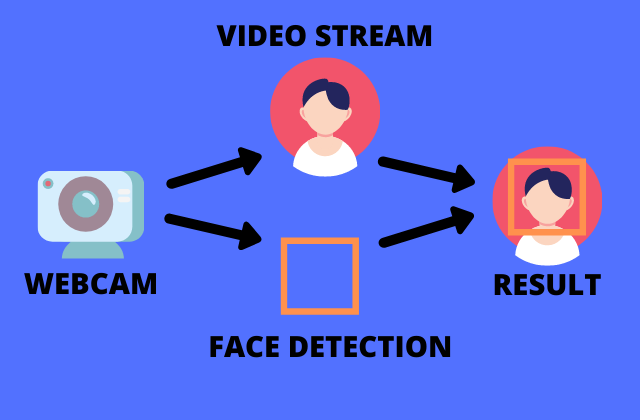</center>

In [13]:
# JavaScript para criar adequadamente nosso fluxo de vídeo ao vivo usando nossa webcam como entrada
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [14]:
# Começar a transmitir vídeo da webcam
video_stream()
# Título do vídeo
label_html = 'Capturing...'
# Inicializar a caixa delimitadora (bounding box) como vazia
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Converter a resposta JS em uma imagem OpenCV
    img = js_to_image(js_reply["img"])

    # Criar uma sobreposição transparente para a caixa delimitadora
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Imagem em escala de cinza para detecção de faces
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Obter coordenadas de região facial
    faces = face_cascade.detectMultiScale(gray)
    # Obter as coordenadas do quadro delimitador da face para sobreposição
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

      # Chamando o nosso ajudante darknet no quadro de vídeo
      detections, width_ratio, height_ratio = darknet_helper(bbox_array, width, height)

      # Faça um loop através das detecções e desenhe-as na imagem de sobreposição transparente
      for label, confidence, bbox in detections:
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # Converter a sobreposição da caixa delimitadora em bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # Atualize o bbox para que o próximo quadro receba uma nova sobreposição
    bbox = bbox_bytes

<IPython.core.display.Javascript object>